In [1]:
import pandas
%load_ext autoreload

%autoreload 2



In [2]:
from mlflow import MlflowClient
import mlflow
import numpy as np
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
import collections
import matplotlib as mpl
import numpy as np
from collections import defaultdict
import scienceplots
from sklearn import datasets
from sklearn.datasets import make_blobs
from cycler import cycler
plt.style.use(['science', 'bright'])


In [3]:
client = MlflowClient(tracking_uri="http://192.168.1.181:5010")
mlflow.set_tracking_uri("http://192.168.1.181:5010")


In [4]:
complexities_df = pd.read_csv('complexities.csv')\
    .rename(columns={"shuffle": "params.data_shuffle_random_state", "dataset_name": "params.dataset", "should_take_test": "params.should_take_test"})\
    .astype({"params.data_shuffle_random_state": str, "params.should_take_test": str, "params.dataset": str})

In [5]:
COMPLEXITY_METRICS = [m for m in complexities_df.columns.tolist()[3:] if 'time' not in m]

In [6]:
def get_runs_for(name, client = client):
    return mlflow.search_runs(client.get_experiment_by_name(name).experiment_id)

In [7]:
CLASSIFICATION_METRICS = ['metrics.tn', 'metrics.tp', 'metrics.fp', 'metrics.fn']
DATASET_PARAMS = ['params.should_take_test', 'params.dataset', 'params.data_shuffle_random_state']
RF_METRICS = ['metrics.depth_mean',
              'metrics.depth_min',
              'metrics.depth_median',
              'metrics.n_leaves_max',
              'metrics.n_leaves_min',
              'metrics.n_leaves_mean',
              'metrics.depth_max',
              'metrics.n_leaves_median',]
QUAD_SPLIT_PARAMS = ['metrics.no_of_predicates_median', 'metrics.complex_clfs',
                     'metrics.rules', 'metrics.no_of_predicates_max',
                     'metrics.dummy_clfs', 'metrics.no_of_predicates_min',
                     'metrics.all_clfs', 'params.min_split_percentage',
                    'params.complexity_measure','params.min_samples']

In [8]:
def calculate_accuracy(row):
    return (row['metrics.tp'] + row['metrics.tn']) / (row['metrics.fp'] + row['metrics.tp'] + row['metrics.tn'] + row['metrics.fn'])

In [9]:
def calculate_recall(row):
    return row['metrics.tp'] / (row['metrics.tp'] + row['metrics.fn'])

def calculate_precision(row):
    return row['metrics.tp'] / (row['metrics.tp'] + row['metrics.fp'])

In [10]:
base_runs_dt = get_runs_for("base_runs_dt")[CLASSIFICATION_METRICS + DATASET_PARAMS + ['metrics.depth', "metrics.n_leaves"]]\
    .assign(test_accuracy=calculate_accuracy) \
    .assign(test_recall=calculate_recall)\
    .assign(test_precision=calculate_precision)

In [11]:
base_runs_rf = get_runs_for("base_runs_rf")[CLASSIFICATION_METRICS + DATASET_PARAMS + RF_METRICS]\
    .assign(test_accuracy=calculate_accuracy) \
    .assign(test_recall=calculate_recall) \
    .assign(test_precision=calculate_precision)

In [12]:
base_runs_oner = (get_runs_for("base_runs_oner")[CLASSIFICATION_METRICS + DATASET_PARAMS + ['metrics.rules_no', 'metrics.depth']]

    .assign(test_accuracy=calculate_accuracy)) \
    .assign(test_recall=calculate_recall) \
    .assign(test_precision=calculate_precision)


In [13]:
base_runs_rulefit = (get_runs_for("base_runs_rulefit")[CLASSIFICATION_METRICS + DATASET_PARAMS + ['metrics.max_rules', 'metrics.rules_no', 'metrics.terms_no']]
    .assign(test_accuracy=calculate_accuracy)) \
    .assign(test_recall=calculate_recall) \
    .assign(test_precision=calculate_precision)


In [14]:
base_runs_greedy = (get_runs_for("base_runs_greedy")[CLASSIFICATION_METRICS + DATASET_PARAMS + ['metrics.depth', 'metrics.rules_no']]
        .assign(test_accuracy=calculate_accuracy))\
    .assign(test_recall=calculate_recall) \
    .assign(test_precision=calculate_precision)

In [15]:
quad_split_runs_v1_df =get_runs_for("09.07-quadsplit-explain-v1")[CLASSIFICATION_METRICS + DATASET_PARAMS + QUAD_SPLIT_PARAMS] \
    .assign(test_accuracy=calculate_accuracy) \
    .assign(test_recall=calculate_recall) \
    .assign(test_precision=calculate_precision)

In [16]:
quad_split_runs_v2_df =get_runs_for("09.07-quadsplit-explain-v2")[CLASSIFICATION_METRICS + DATASET_PARAMS + QUAD_SPLIT_PARAMS] \
    .assign(test_accuracy=calculate_accuracy) \
    .assign(test_recall=calculate_recall) \
    .assign(test_precision=calculate_precision)

In [17]:
base_runs_rf.rename(columns={c: c+'_rf' for c in base_runs_rf.columns if 'metric' in c or 'test_' in c}, inplace=True)
base_runs_dt.rename(columns={c: c+'_dt' for c in base_runs_dt.columns if 'metric' in c  or 'test_' in c}, inplace=True)
base_runs_greedy.rename(columns={c: c+'_greedy' for c in base_runs_greedy.columns if 'metric' in c or 'test_' in c}, inplace=True)
base_runs_oner.rename(columns={c: c+'_oner' for c in base_runs_oner.columns if 'metric' in c or 'test_' in c}, inplace=True)
base_runs_rulefit.rename(columns={c: c+'_rulefit' for c in base_runs_rulefit.columns if 'metric' in c or 'test_' in c}, inplace=True)
quad_split_runs_v1_df.rename(columns={c: c+'_v1' for c in quad_split_runs_v1_df.columns if 'metric' in c or 'test_' in c}, inplace=True)
quad_split_runs_v2_df.rename(columns={c: c+'_v2' for c in quad_split_runs_v2_df.columns if 'metric' in c or 'test_' in c}, inplace=True)

In [22]:
base_runs_together_df = pd.merge(
    base_runs_dt,
    base_runs_rf,
    how='right',
    on=DATASET_PARAMS,
    suffixes=('_dt', '_rf')
)\
    .merge(base_runs_greedy, how='right', on=DATASET_PARAMS, suffixes=('', '_greedy'))\
    .merge(base_runs_oner, how='right', on=DATASET_PARAMS, suffixes=('', '_oner'))\
    .merge(base_runs_rulefit, how='right', on=DATASET_PARAMS, suffixes=('', '_rulefit'))\
    .dropna()
quad_split_df = pd.merge(
    base_runs_together_df,
    quad_split_runs_v1_df,
    how='right',
    on=DATASET_PARAMS,
    suffixes=('', '_v1')
)
quad_split_df = pd.merge(
    quad_split_df,
    quad_split_runs_v2_df,
    how='right',
    on=DATASET_PARAMS,
    suffixes=('', '_v2')
)
quad_split_df = pd.merge(
    quad_split_df,
    complexities_df,
    how='left',
    on=DATASET_PARAMS
)

In [24]:
LABELS_THAT_SHOULD_BE =["better", "equal", "worse"] 

In [25]:
quad_split_df.dropna(inplace=True)

In [26]:
LIMITING_QUERY = "`params.min_samples` == '28' and `params.min_split_percentage` == '0.183'"

In [27]:
quad_split_df.dropna(inplace=True)

In [28]:
METRICS = ['test_accuracy', 'test_recall', 'test_precision']

In [29]:
SUFFIXES = ["_dt", "_rf", "_oner", "_rulefit", "_greedy"]

In [32]:
def define_comparison(row, suffix, metric, v):
    if row[f'{metric}{v}_equal{suffix}']:
        return "equal"
    if row[f'{metric}{v}_better{suffix}']:
        return "better"
    else:
        return "worse"

In [33]:
for suffix in SUFFIXES:
    for metric in METRICS:
        for v in ["_v1", "_v2"]:
            quad_split_df[f'{metric}{v}_diff_to{suffix}'] = quad_split_df[f"{metric}{v}"] - quad_split_df[f'{metric}{suffix}']
            quad_split_df[f'{metric}{v}_better_equal{suffix}'] = quad_split_df[f"{metric}{v}"] >= quad_split_df[f'{metric}{suffix}']
            quad_split_df[f'{metric}{v}_better{suffix}'] = quad_split_df[f"{metric}{v}"] > quad_split_df[f'{metric}{suffix}']
            quad_split_df[f'{metric}{v}_worse{suffix}'] = ~quad_split_df[f'{metric}{v}_better_equal{suffix}']
            quad_split_df[f'{metric}{v}_worse_equal{suffix}'] = ~quad_split_df[f'{metric}{v}_better{suffix}']
            quad_split_df[f'{metric}{v}_equal{suffix}'] = quad_split_df[f"{metric}{v}"] == quad_split_df[f'{metric}{suffix}']
            quad_split_df[f'{metric}{v}_comparison{suffix}'] = quad_split_df.apply(lambda row: define_comparison(row, suffix, metric, v), axis=1)

/var/folders/fd/dyfc8ph167q7r5pf9y8451540000gn/T/ipykernel_3081/2279284652.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  quad_split_df[f'{metric}{v}_diff_to{suffix}'] = quad_split_df[f"{metric}{v}"] - quad_split_df[f'{metric}{suffix}']
/var/folders/fd/dyfc8ph167q7r5pf9y8451540000gn/T/ipykernel_3081/2279284652.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  quad_split_df[f'{metric}{v}_better_equal{suffix}'] = quad_split_df[f"{metric}{v}"] >= quad_split_df[f'{metric}{suffix}']
/var/folders/fd/dyfc8ph167q7r5pf9y8451540000

In [34]:
QUAD_SPLIT_PARAMS

['metrics.no_of_predicates_median',
 'metrics.complex_clfs',
 'metrics.rules',
 'metrics.no_of_predicates_max',
 'metrics.dummy_clfs',
 'metrics.no_of_predicates_min',
 'metrics.all_clfs',
 'params.min_split_percentage',
 'params.complexity_measure',
 'params.min_samples']

In [ ]:
quad_split_df['complexity_rf'] = quad_split_df['metrics.depth_median_rf'] * 32 * quad_split_df['metrics.n_leaves_median_rf']
quad_split_df['complexity'] =  quad_split_df['metrics.rules']
quad_split_df['complexity_dt'] = quad_split_df['metrics.depth_dt'] * quad_split_df['metrics.n_leaves_dt']
quad_split_df['complexity_rulefit'] = quad_split_df['metrics.rules_no_rulefit']
quad_split_df['complexity_oner'] = quad_split_df['metrics.rules_no_oner']


In [35]:
for metric in COMPLEXITY_METRICS:
    quad_split_df[f'{metric}-discretized'] = pd.qcut(quad_split_df[metric], 3, labels=["low", "medium", "high"])


/var/folders/fd/dyfc8ph167q7r5pf9y8451540000gn/T/ipykernel_3081/316881999.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  quad_split_df[f'{metric}-discretized'] = pd.qcut(quad_split_df[metric], 3, labels=["low", "medium", "high"])
/var/folders/fd/dyfc8ph167q7r5pf9y8451540000gn/T/ipykernel_3081/316881999.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  quad_split_df[f'{metric}-discretized'] = pd.qcut(quad_split_df[metric], 3, labels=["low", "medium", "high"])
/var/folders/fd/dyfc8ph167q7r5pf9y8451540000gn/T/ipykernel_3081/

In [36]:
ALL_DISCRETIZED_METRICS = [f'{metric}-discretized' for metric in COMPLEXITY_METRICS]

In [37]:
compare_values = {
    "low": 0,
    "medium": 1,
    "high": 2,
}
compare_values_inverted = {
    v: k for k, v in compare_values.items()
}
def take_higher(row):
    vals = [compare_values[it] for it in [row[0], row[1]]]
    max_val = max(vals)
    
    return compare_values_inverted[max_val]

In [38]:
quad_split_df['overall-complexity'] = quad_split_df[ALL_DISCRETIZED_METRICS].mode(axis=1).fillna('low').apply(take_higher, axis=1)

/var/folders/fd/dyfc8ph167q7r5pf9y8451540000gn/T/ipykernel_3081/2910056351.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  quad_split_df['overall-complexity'] = quad_split_df[ALL_DISCRETIZED_METRICS].mode(axis=1).fillna('low').apply(take_higher, axis=1)


# COMPARISON TO ALGORITHSM

In [39]:
quad_split_df\
    .query(LIMITING_QUERY)\
    [ALL_DISCRETIZED_METRICS].apply(lambda x:x.value_counts())

,f1-discretized,f2-discretized,f3-discretized,f4-discretized,f1v-discretized,c1-discretized,c2-discretized,l1-discretized,l2-discretized,l3-discretized,...,n3-discretized,n4-discretized,t1-discretized,t2-discretized,t3-discretized,t4-discretized,clsCoef-discretized,hubs-discretized,density-discretized,lsc-discretized
low,5076,5070,5184,5070,5076,5724,5724,5076,5076,5076,...,5070,5076,5076,5508,5076,5400,5076,5178,5070,5070
medium,4968,5076,4854,5076,4962,4314,4314,4962,4962,4968,...,4968,4962,4962,4860,5292,5502,4962,4860,4968,4968
high,4962,4860,4968,4860,4968,4968,4968,4968,4968,4962,...,4968,4968,4968,4638,4638,4104,4968,4968,4968,4968


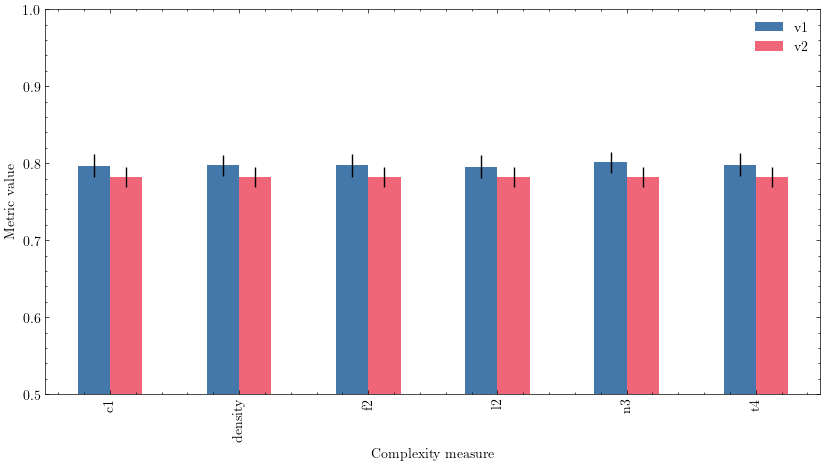

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

err_vars = quad_split_df.groupby(["params.complexity_measure"])[['test_accuracy_v1', 'test_accuracy_v2']].var()

df_to_plot = quad_split_df.groupby(["params.complexity_measure"])[['test_accuracy_v1', 'test_accuracy_v2']].mean()

df_to_plot.plot(kind='bar', ax=ax, yerr=err_vars)

ax.set_ylim(0.5, 1)

ax.legend(["v1", "v2"])
ax.set_xlabel("Complexity measure")
ax.set_ylabel("Metric value")
# ax.axhline(df_to_plot.test_accuracy.max())
# for container in ax.containers:
#     ax.bar_label(container)
# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='center right')
fig.savefig('../figures/quad/explainable-complexity-metric-comparison.pdf')

In [43]:
LIMITING_QUERY = "`params.min_samples` == '28' and `params.min_split_percentage` == '0.183' and `params.complexity_measure` == 'density'"

In [44]:
def vals_to_percentage(l):
    total = sum(l)
    
    return [round(item/total*100,2) for item in l]
    

## WINS-LOSSES acc general

In [47]:
def plot_bar(labels, values_dict, quants, ax):
    plot_labels = [l.split('_')[-1].upper() for l in labels]
    data = np.array(list(values_dict.values()))
    data_cum = data.cumsum(axis=1)
        
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, colname in enumerate(quants):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(plot_labels, widths, left=starts, height=0.5, label=colname)

        ax.bar_label(rects, label_type='center')




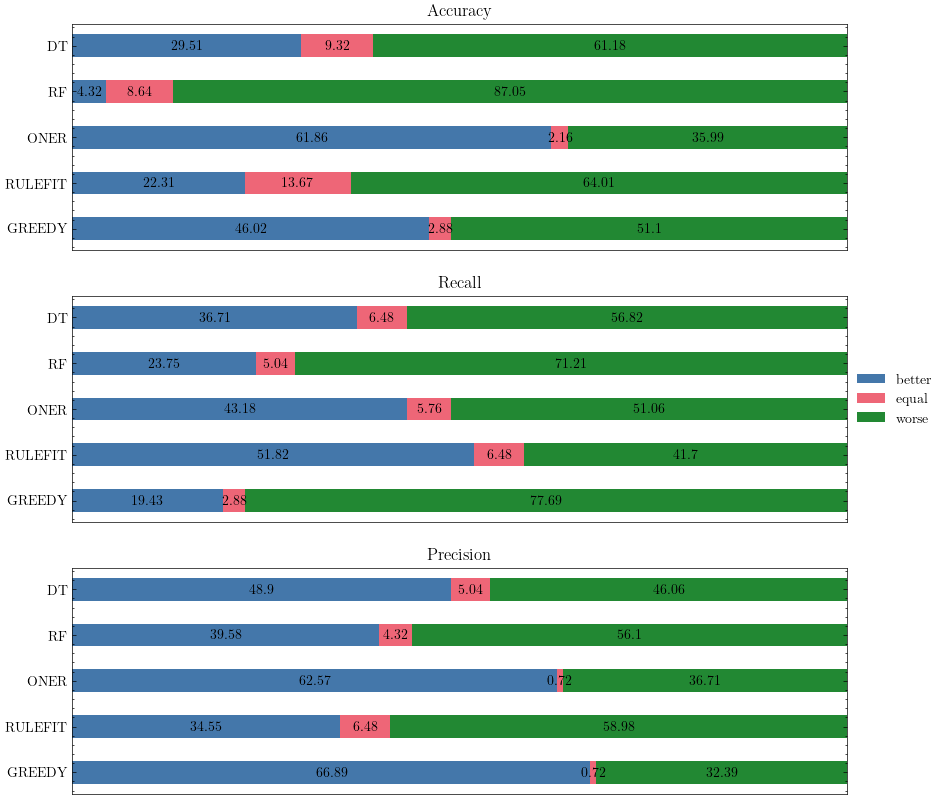

In [50]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(10, 10))

ax1.set_title("Accuracy")
labels = [f"test_accuracy_v1_comparison{suffix}" for suffix in SUFFIXES]
vals_to_plot = {k: vals_to_percentage(v.values()) for k,v in quad_split_df.query(LIMITING_QUERY)[labels].apply(pd.Series.value_counts).reindex(LABELS_THAT_SHOULD_BE).to_dict().items()}
plot_bar(labels, vals_to_plot, ['better', 'equal', 'worse'], ax1)

ax2.set_title("Recall")
labels = [f"test_recall_v1_comparison{suffix}" for suffix in SUFFIXES]
vals_to_plot = {k: vals_to_percentage(v.values()) for k,v in quad_split_df.query(LIMITING_QUERY)[labels].apply(pd.Series.value_counts).reindex(LABELS_THAT_SHOULD_BE).to_dict().items()}
plot_bar(labels, vals_to_plot, ['better', 'equal', 'worse'], ax2)

ax3.set_title("Precision")
labels = [f"test_precision_v1_comparison{suffix}" for suffix in SUFFIXES]
vals_to_plot = {k: vals_to_percentage(v.values()) for k,v in quad_split_df.query(LIMITING_QUERY)[labels].apply(pd.Series.value_counts).reindex(LABELS_THAT_SHOULD_BE).to_dict().items()}
plot_bar(labels, vals_to_plot, ['better', 'equal', 'worse'], ax3)

handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')

fig.savefig('../figures/quad/explanations-v1-overall-performance-barplot.pdf')

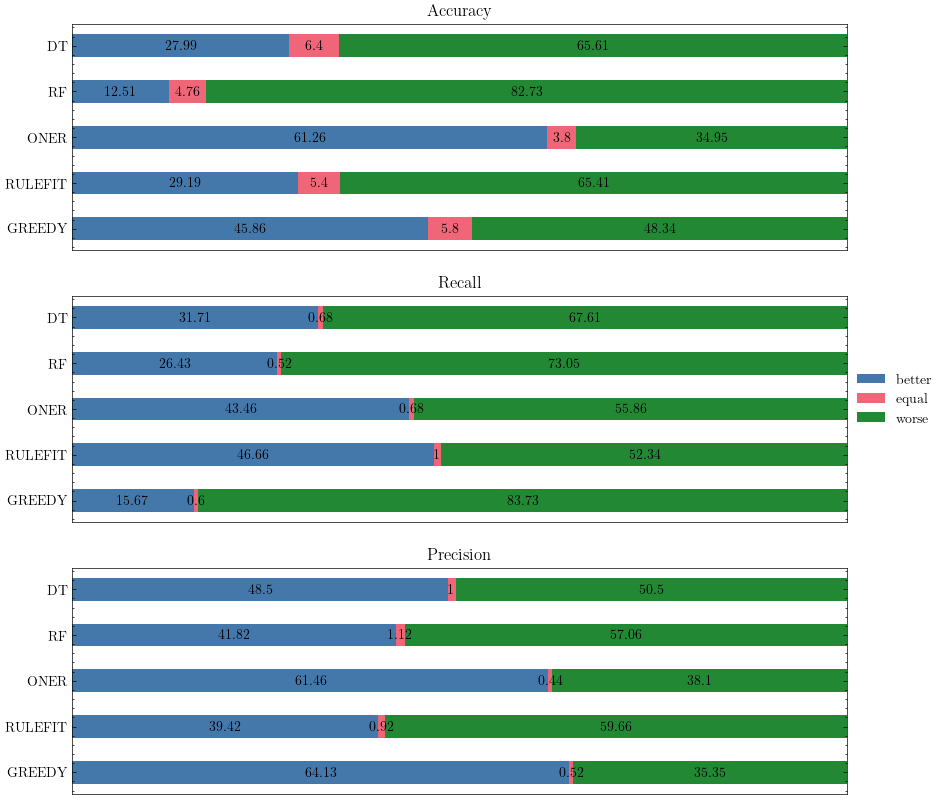

In [51]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(10, 10))

ax1.set_title("Accuracy")
labels = [f"test_accuracy_v2_comparison{suffix}" for suffix in SUFFIXES]
vals_to_plot = {k: vals_to_percentage(v.values()) for k,v in quad_split_df.query(LIMITING_QUERY)[labels].apply(pd.Series.value_counts).reindex(LABELS_THAT_SHOULD_BE).to_dict().items()}
plot_bar(labels, vals_to_plot, ['better', 'equal', 'worse'], ax1)

ax2.set_title("Recall")
labels = [f"test_recall_v2_comparison{suffix}" for suffix in SUFFIXES]
vals_to_plot = {k: vals_to_percentage(v.values()) for k,v in quad_split_df.query(LIMITING_QUERY)[labels].apply(pd.Series.value_counts).reindex(LABELS_THAT_SHOULD_BE).to_dict().items()}
plot_bar(labels, vals_to_plot, ['better', 'equal', 'worse'], ax2)

ax3.set_title("Precision")
labels = [f"test_precision_v2_comparison{suffix}" for suffix in SUFFIXES]
vals_to_plot = {k: vals_to_percentage(v.values()) for k,v in quad_split_df.query(LIMITING_QUERY)[labels].apply(pd.Series.value_counts).reindex(LABELS_THAT_SHOULD_BE).to_dict().items()}
plot_bar(labels, vals_to_plot, ['better', 'equal', 'worse'], ax3)

handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')

fig.savefig('../figures/quad/explanations-v2-overall-performance-barplot.pdf')

In [ ]:
ACC_LABELS = [f"test_accuracy_comparison{suffix}" for suffix in SUFFIXES]
PRECISION_LABLES = [f"test_precision_comparison{suffix}" for suffix in SUFFIXES]
RECALL_LABLES = [f"test_recall_comparison{suffix}" for suffix in SUFFIXES]

In [ ]:
COMPLEXITIES_TO_CONSIDER = ['f2', 't4', 'c1', 'n3', 'l2', 'density']

In [ ]:
COMPLEXITIES_WITH_HIGHEST_VARIANCE = ['f2', 't4', 'c1', 'n3', 'l2', 'density']

In [ ]:
def make_sure_all_labels_are_there(df):
    missing_labels = set(LABELS_THAT_SHOULD_BE) - set(df.index)

    for label in missing_labels:
        df.loc[label] = pd.Series()

    return df.reindex(LABELS_THAT_SHOULD_BE)

In [ ]:
fig, axes = plt.subplots(3,3, sharey=True, figsize=(20, 10))

axes = axes.reshape(-1)

axes_iter = iter(axes)
plot_labels = [l.split('_')[-1].upper() for l in ACC_LABELS]



for labels, label in zip([ACC_LABELS, RECALL_LABLES, PRECISION_LABLES], ["Accuracy", "Recall", "Precision"]):
    for value in ['low', 'medium', 'high']:
        ax = next(axes_iter)
        vals_to_plot = {k: vals_to_percentage(v.values()) for k,v in make_sure_all_labels_are_there(quad_split_df.query(LIMITING_QUERY).query(f"`overall-complexity` == '{value}'")[labels].apply(pd.Series.value_counts)).fillna(0).to_dict().items()}
    
        data = np.array(list(vals_to_plot.values()))
        data_cum = data.cumsum(axis=1)
        ax.invert_yaxis()
        ax.xaxis.set_visible(False)
        # ax.yaxis.set_visible(False)
        ax.set_xlim(0, np.sum(data, axis=1).max())

        for i, colname in enumerate(['better', 'equal', 'worse']):
            widths = data[:, i]
            starts = data_cum[:, i] - widths
            rects = ax.barh(plot_labels, widths, left=starts, height=0.5, label=colname)
            ax.bar_label(rects, label_type='center')
    
        ax.set_title(f"complexity {value} {label}")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
fig.savefig("../figures/quad/overall-complexity-barplot.pdf")

In [ ]:
fig, axes = plt.subplots(1,3, sharey=True, figsize=(20, 5))

axes = axes.reshape(-1)

axes_iter = iter(axes)
plot_labels = [l.split('_')[-1].upper() for l in ACC_LABELS]


for value in ['low', 'medium', 'high']:

    ax = next(axes_iter)
    vals_to_plot = {k:  vals_to_percentage(v.values()) for k,v in quad_split_df.query(LIMITING_QUERY).query(f"`overall-complexity` == '{value}'")[ACC_LABELS].apply(pd.Series.value_counts).reindex(LABELS_THAT_SHOULD_BE).fillna(0).to_dict().items()}

    data = np.array(list(vals_to_plot.values()))
    data_cum = data.cumsum(axis=1)
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, colname in enumerate(['better', 'equal', 'worse']):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(plot_labels, widths, left=starts, height=0.5, label=colname)
        ax.bar_label(rects, label_type='center')

    ax.set_title(f"complexity {value}")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
fig.savefig("../figures/quad/accuracy-overall-complexity-barplot.pdf")

## Models complexity

In [ ]:
MODEL_COMPLEXITY_LABELS = ['complexity',"complexity_rf", "complexity_dt", 'complexity_rulefit', "complexity_oner"]
MODEL_COMPLEXITY_LABELS_WO_RF = ['complexity', "complexity_dt", 'complexity_rulefit', "complexity_oner"]


In [ ]:
quad_split_df[MODEL_COMPLEXITY_LABELS]

In [ ]:
quad_split_df.query(LIMITING_QUERY).groupby("overall-complexity")[MODEL_COMPLEXITY_LABELS_WO_RF].mean().plot(kind='bar')

In [ ]:
quad_split_df.query(LIMITING_QUERY).groupby("overall-complexity")[MODEL_COMPLEXITY_LABELS_WO_RF].var().plot(kind='bar')

In [ ]:
order = pd.Categorical([ 'low', 'medium', 'high'],ordered=True)

In [ ]:
quad_split_df \
    .query(LIMITING_QUERY) \
    .groupby('overall-complexity')[['complexity_dt', 'complexity']] \
    .mean().transpose()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 7))

quad_split_df\
    .query(LIMITING_QUERY) \
    [['test_accuracy_better_rf'] + ALL_DISCRETIZED_METRICS] \
    .melt('test_accuracy_better_rf')\
    .groupby(['variable', 'value'], as_index=False)['test_accuracy_better_rf'].var()\
    .groupby('variable')['test_accuracy_better_rf'].var()\
    .rename(index=lambda name: name.split('-')[0]).plot(kind='pie', ax=ax1)

ax1.set_title("Variance of wins against Random Forest")

quad_split_df\
    .query(LIMITING_QUERY) \
    [['test_accuracy_better_dt'] + ALL_DISCRETIZED_METRICS] \
    .melt('test_accuracy_better_dt')\
    .groupby(['variable', 'value'], as_index=False).apply(lambda x: np.sum(x)/len(x))\
    .groupby('variable')['test_accuracy_better_dt'].var()\
    .rename(index=lambda name: name.split('-')[0]).plot(kind='pie', ax=ax2)

ax2.set_title("Variance of wins against Decision Tree")
fig.savefig('../figures/quad/variance-of-wins.pdf')

In [ ]:
most_variance_metrics = quad_split_df\
    .query(LIMITING_QUERY) \
    [['test_accuracy_better_dt'] + ALL_DISCRETIZED_METRICS] \
    .melt('test_accuracy_better_dt')\
    .groupby(['variable', 'value'], as_index=False).apply(lambda x: np.sum(x)/len(x))\
    .groupby('variable')['test_accuracy_better_dt'].var().sort_values(ascending=False)[:5].index

In [ ]:
most_variance_metrics = set(most_variance_metrics).union(quad_split_df\
    .query(LIMITING_QUERY) \
    [['test_accuracy_better_rf'] + ALL_DISCRETIZED_METRICS] \
    .melt('test_accuracy_better_rf')\
    .groupby(['variable', 'value'], as_index=False).apply(lambda x: np.sum(x)/len(x))\
    .groupby('variable')['test_accuracy_better_rf'].var().sort_values(ascending=False)[:4].index)

In [ ]:
COMPLEXITIES_TO_CONSIDER = [m.split("-")[0]  for m in most_variance_metrics]

In [ ]:
fig, axes = plt.subplots(len(COMPLEXITIES_TO_CONSIDER),3,figsize=(20, 20), sharey='row')

axes = axes.reshape(-1)

axes_iter = iter(axes)
for complexity in COMPLEXITIES_TO_CONSIDER:
    plot_labels = [l.split('_')[-1].upper() for l in ACC_LABELS]
    
    
    for value in ['low', 'medium', 'high']:

        ax = next(axes_iter)
        vals_to_plot = {k:  vals_to_percentage(v.values()) for k,v in quad_split_df.query(LIMITING_QUERY).query('`params.base_clf` == "dt"').query(f"`{complexity}-discretized` == '{value}'")[ACC_LABELS].apply(pd.Series.value_counts).reindex(LABELS_THAT_SHOULD_BE).fillna(0).to_dict().items()}

        data = np.array(list(vals_to_plot.values()))
        data_cum = data.cumsum(axis=1)
        ax.invert_yaxis()
        ax.xaxis.set_visible(False)
        ax.set_xlim(0, np.sum(data, axis=1).max())
    
        for i, colname in enumerate(['better', 'equal', 'worse']):
            widths = data[:, i]
            starts = data_cum[:, i] - widths
            rects = ax.barh(plot_labels, widths, left=starts, height=0.5, label=colname)
            ax.bar_label(rects, label_type='center')
    
        ax.set_title(f"{complexity}-{value}")


handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
fig.savefig('../figures/quad/accuracy-with-variance-complexity-metrics-barplot.pdf')
